<img src="../../thumbnail.png" width=250 alt="CESM LENS image"></img>

# Reproducing Key Figures from Kay et al. (2015)

---

## Overview
This notebook demonstrates how one might use the NCAR Community Earth System Model (CESM) Large Ensemble (LENS) data hosted on AWS S3. The notebook shows how to reproduce figures 2 and 4 from the [Kay et al. (2015) paper](https://doi.org/10.1175/BAMS-D-13-00255.1) describing the CESM LENS dataset {cite:p}`Kay:2015a`.

This resource is intended to be helpful for people not familiar with elements of the [Pangeo](https://pangeo.io/) framework including Jupyter Notebooks, [Xarray](https://docs.xarray.dev/en/stable/), and [Zarr](https://zarr.readthedocs.io/en/stable/) data format, or with the original paper, so it includes additional explanation.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| Dask | Helpful | |

- **Time to learn**: 30 minutes

---

<div class="alert alert-warning"><b>NOTE: </b>In this notebook, we access very large cloud-served datasets and use <a href="https://dask.org">Dask</a> to parallelize our workflow. The end-to-end execution time may be on the order of an hour or more, depending on your computing resources.</div>

## Imports

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import intake
import matplotlib.pyplot as plt
from dask.distributed import Client
import numpy as np
import pandas as pd
import xarray as xr
import cmaps  # for NCL colormaps
import cartopy.crs as ccrs
import dask
import s3fs

In [2]:
dask.config.set({"distributed.scheduler.worker-saturation": 1.0})

## Create and Connect to Dask Distributed Cluster

Here we'll use a dask cluster to parallelize our analysis.

In [3]:
platform = sys.platform

if (platform == 'win32'):
    import multiprocessing.popen_spawn_win32
else:
    import multiprocessing.popen_spawn_posix

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32819,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.37 GiB
Comm: tcp://127.0.0.1:39737,Total threads: 2
Dashboard: http://127.0.0.1:43611/status,Memory: 7.34 GiB
Nanny: tcp://127.0.0.1:36837,


## Load and Prepare Data

In [5]:
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake.open_esm_datastore(catalog_url)
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


Show the first few lines of the catalog:

In [6]:
col.df.head(10)

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,FLNSC,clearsky net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...
2,FLUT,upwelling longwave flux at top of model,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....
3,FSNS,net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....
4,FSNSC,clearsky net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...
5,FSNTOA,net solar flux at top of atmosphere,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNTO...
6,ICEFRAC,fraction of sfc area covered by sea-ice,atm,20C,daily,1.0,global,fraction,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-ICEFR...
7,LHFLX,surface latent heat flux,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-LHFLX...
8,PRECL,large-scale (stable) precipitation rate (liq +...,atm,20C,daily,1.0,global,m/s,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECL...
9,PRECSC,convective snow rate (water equivalent),atm,20C,daily,1.0,global,m/s,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECS...


Show expanded version of collection structure with details:

In [7]:
col.keys_info().head()

,component,experiment,frequency
key,,,
atm.20C.daily,atm,20C,daily
atm.20C.hourly6-1990-2005,atm,20C,hourly6-1990-2005
atm.20C.monthly,atm,20C,monthly
atm.20C.static,atm,20C,static
atm.CTRL.daily,atm,CTRL,daily


### Extract data needed to construct Figure 2

Search the catalog to find the desired data, in this case the reference height temperature of the atmosphere, at daily time resolution, for the Historical, 20th Century, and RCP8.5 (IPCC Representative Concentration Pathway 8.5) experiments.

In [8]:
col_subset = col.search(frequency=["daily", "monthly"], component="atm", variable="TREFHT",
                        experiment=["20C", "RCP85", "HIST"])

col_subset

,unique
variable,1
long_name,1
component,1
experiment,3
frequency,2
vertical_levels,1
spatial_domain,1
units,1
start_time,6
end_time,6


In [9]:
col_subset.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TREFHT,reference height temperature,atm,20C,daily,1.0,global,K,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TREFH...
1,TREFHT,reference height temperature,atm,HIST,daily,1.0,global,K,1850-01-01 12:00:00,1919-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-HIST-TREF...
2,TREFHT,reference height temperature,atm,RCP85,daily,1.0,global,K,2006-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-TRE...
3,TREFHT,reference height temperature,atm,20C,monthly,1.0,global,K,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-TRE...
4,TREFHT,reference height temperature,atm,HIST,monthly,1.0,global,K,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-TR...
5,TREFHT,reference height temperature,atm,RCP85,monthly,1.0,global,K,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...


Load catalog entries for subset into a dictionary of Xarray Datasets:

In [10]:
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['atm.HIST.monthly', 'atm.20C.monthly', 'atm.RCP85.monthly', 'atm.HIST.daily', 'atm.20C.daily', 'atm.RCP85.daily'])


Define Xarray Datasets corresponding to the three experiments:

In [11]:
ds_HIST = dsets['atm.HIST.monthly']
ds_20C = dsets['atm.20C.daily']
ds_RCP85 = dsets['atm.RCP85.daily']

Use the `dask.distributed` utility function to display size of each dataset:

In [12]:
from dask.utils import format_bytes
print(f"Historical: {format_bytes(ds_HIST.nbytes)}\n"
      f"20th Century: {format_bytes(ds_20C.nbytes)}\n"
      f"RCP8.5: {format_bytes(ds_RCP85.nbytes)}")

Historical: 177.21 MiB
20th Century: 258.65 GiB
RCP8.5: 285.71 GiB


Now, extract the Reference Height Temperature data variable:

In [13]:
t_hist = ds_HIST["TREFHT"]
t_20c = ds_20C["TREFHT"]
t_rcp = ds_RCP85["TREFHT"]
t_20c

<xarray.DataArray 'TREFHT' (member_id: 40, time: 31390, lat: 192, lon: 288)> Size: 278GB
dask.array<open_dataset-TREFHT, shape=(40, 31390, 192, 288), dtype=float32, chunksize=(1, 576, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 251kB 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

The global surface temperature anomaly was computed relative to the 1961-90 base period in the Kay et al. paper, so extract that time slice:

In [14]:
t_ref = t_20c.sel(time=slice("1961", "1990"))

## Figure 2

### Read grid cell areas

Cell size varies with latitude, so this must be accounted for when computing the global mean.

In [15]:
cat = col.search(frequency="static", component="atm", experiment=["20C"])
_, grid = cat.to_dataset_dict(aggregate=False, storage_options={'anon':True}, zarr_kwargs={"consolidated": True}).popitem()
grid


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.long_name.component.experiment.frequency.vertical_levels.spatial_domain.units.start_time.end_time.path'


<xarray.Dataset> Size: 242kB
Dimensions:   (lat: 192, lon: 288, ilev: 31, lev: 30, bnds: 2, slat: 191,
               slon: 288)
Coordinates: (12/20)
    P0        float64 8B ...
    area      (lat, lon) float32 221kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    gw        (lat) float64 2kB dask.array<chunksize=(192,), meta=np.ndarray>
    hyai      (ilev) float64 248B dask.array<chunksize=(31,), meta=np.ndarray>
    hyam      (lev) float64 240B dask.array<chunksize=(30,), meta=np.ndarray>
    hybi      (ilev) float64 248B dask.array<chunksize=(31,), meta=np.ndarray>
    ...        ...
    ntrm      int32 4B ...
    ntrn      int32 4B ...
  * slat      (slat) float64 2kB -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon      (slon) float64 2kB -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
    w_stag    (slat) float64 2kB dask.array<chunksize=(191,), meta=np.ndarray>
    wnummax   (lat) int32 768B dask.array<chunksize=(192,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    *empty*
Attributes:
    intake_esm_vars:                  nan
    intake_esm_attrs:component:       atm
    intake_esm_attrs:experiment:      20C
    intake_esm_attrs:frequency:       static
    intake_esm_attrs:spatial_domain:  global
    intake_esm_attrs:path:            s3://ncar-cesm-lens/atm/static/grid.zarr
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           atm.20C.static.global.s3://ncar-cesm-le...

In [16]:
cell_area = grid.area.load()
total_area = cell_area.sum()
cell_area

<xarray.DataArray 'area' (lat: 192, lon: 288)> Size: 221kB
array([[2.994837e+07, 2.994837e+07, 2.994837e+07, ..., 2.994837e+07,
        2.994837e+07, 2.994837e+07],
       [2.395748e+08, 2.395748e+08, 2.395748e+08, ..., 2.395748e+08,
        2.395748e+08, 2.395748e+08],
       [4.790848e+08, 4.790848e+08, 4.790848e+08, ..., 4.790848e+08,
        4.790848e+08, 4.790848e+08],
       ...,
       [4.790848e+08, 4.790848e+08, 4.790848e+08, ..., 4.790848e+08,
        4.790848e+08, 4.790848e+08],
       [2.395748e+08, 2.395748e+08, 2.395748e+08, ..., 2.395748e+08,
        2.395748e+08, 2.395748e+08],
       [2.994837e+07, 2.994837e+07, 2.994837e+07, ..., 2.994837e+07,
        2.994837e+07, 2.994837e+07]], dtype=float32)
Coordinates:
    P0       float64 8B 1e+05
    area     (lat, lon) float32 221kB 2.995e+07 2.995e+07 ... 2.995e+07
    gw       (lat) float64 2kB 3.382e-05 nan nan nan ... nan nan nan 3.382e-05
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    ntrk     int32 4B 1
    ntrm     int32 4B 1
    ntrn     int32 4B 1
    wnummax  (lat) int32 768B 1 -2147483648 -2147483648 ... -2147483648 1
Attributes:
    long_name:      Grid-Cell Area
    standard_name:  cell_area
    units:          m2

### Define weighted means

Note: `resample(time="AS")` does an annual resampling based on start of calendar year. See documentation for [Pandas resampling options](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).

In [17]:
t_ref_ts = (
    (t_ref.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
    / total_area
).mean(dim=("time", "member_id"))

t_hist_ts = (
    (t_hist.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_20c_ts = (
    (t_20c.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_rcp_ts = (
    (t_rcp.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

### Read data and compute means

Dask’s "lazy execution" philosophy means that until this point we have not actually read the bulk of the data. Steps 1, 3, and 4 take a while to complete, so we include the Notebook "cell magic" directive `%%time` to display elapsed and CPU times after computation.

Step 1 (takes a while)

In [18]:
%%time
# this cell takes a while, be patient
t_ref_mean = t_ref_ts.load()
t_ref_mean

CPU times: user 17.6 s, sys: 2.95 s, total: 20.5 s
Wall time: 3min 36s


<xarray.DataArray ()> Size: 4B
array(286.38763, dtype=float32)
Coordinates:
    P0       float64 8B 1e+05
    ntrk     int32 4B 1
    ntrm     int32 4B 1
    ntrn     int32 4B 1

Step 2 (executes quickly)

In [19]:
%%time 
t_hist_ts_df = t_hist_ts.to_series().T
#t_hist_ts_df.head()

CPU times: user 418 ms, sys: 31.4 ms, total: 449 ms
Wall time: 3.54 s


Step 3 (takes even longer than Step 1)

In [20]:
%%time
t_20c_ts_df = t_20c_ts.to_series().unstack().T
t_20c_ts_df.head()

CPU times: user 49.3 s, sys: 8.15 s, total: 57.4 s
Wall time: 11min 33s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
1920-01-01 00:00:00,286.311310,286.346710,286.283875,286.363983,286.328400,286.373444,286.386017,286.302185,286.374878,286.348358,...,286.243469,286.283783,286.173859,286.309509,286.296234,286.341064,286.341187,286.376831,286.321167,286.254822
1921-01-01 00:00:00,286.250641,286.198181,286.287292,286.390564,286.309204,286.334229,286.311310,286.300232,286.315857,286.305603,...,286.179413,286.315643,286.075104,286.295990,286.318085,286.375305,286.246063,286.356201,286.492493,286.224274
1922-01-01 00:00:00,286.293488,286.296356,286.265686,286.336517,286.293579,286.220093,286.010773,286.195099,286.205170,286.396545,...,286.142365,286.316254,286.140167,286.293549,286.327972,286.142365,286.412598,286.369232,286.503418,286.282074
1923-01-01 00:00:00,286.329163,286.322662,286.251099,286.322723,286.237457,286.152069,286.066010,286.204498,286.271423,286.292236,...,286.168762,286.300781,286.095490,286.116302,286.227905,286.226471,286.512909,286.381348,286.215302,286.396332
1924-01-01 00:00:00,286.307465,286.237366,286.148895,286.311890,286.361694,286.185974,286.248322,286.288177,286.330444,286.411835,...,286.143066,286.287079,286.234100,286.199890,286.252777,286.322815,286.256195,286.221588,286.247437,286.422028


Step 4 (similar to Step 3 in its execution time)

In [21]:
%%time
# This also takes a while
t_rcp_ts_df = t_rcp_ts.to_series().unstack().T
t_rcp_ts_df.head()

CPU times: user 52.2 s, sys: 7.67 s, total: 59.9 s
Wall time: 10min 44s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,286.764832,286.960358,286.679230,286.793152,286.754547,287.022339,286.850464,287.089844,286.960022,286.775787,...,286.866089,286.925049,286.663971,286.955414,286.712524,287.115601,286.863556,286.881683,287.308411,287.030334
2007-01-01 00:00:00,287.073792,286.908539,286.808746,286.998901,286.841675,286.993042,286.914124,286.938965,286.933563,286.675385,...,286.804108,286.849548,286.628204,287.010529,286.811554,287.187225,286.862823,287.008270,287.222534,287.239044
2008-01-01 00:00:00,287.104095,286.815033,286.995056,287.081543,287.100708,286.960510,286.854706,286.878937,287.062927,286.702454,...,286.825653,286.844086,286.811859,286.803741,286.956635,287.080994,286.930084,286.945801,287.087128,287.157745
2009-01-01 00:00:00,286.984497,287.059448,287.010498,287.144714,286.948700,287.092316,286.888458,287.050934,287.138428,286.890839,...,286.785797,286.876556,286.953094,287.060364,287.056946,287.124908,287.005615,287.083984,287.254211,287.060730
2010-01-01 00:00:00,286.991821,287.102295,286.988129,286.875183,286.954407,287.121796,286.938843,287.116211,286.957245,287.049622,...,286.937317,286.928314,286.980499,287.118713,287.178040,287.030212,287.114716,287.083038,287.256927,287.066528


### Get observations for Figure 2 (HadCRUT4)

The HadCRUT4 temperature dataset is described by {cite:t}`Morice:2012a`.

Observational time series data for comparison with ensemble average:

In [22]:
obsDataURL = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc"
ds = xr.open_dataset(obsDataURL).load()
ds

<xarray.Dataset> Size: 21MB
Dimensions:    (lat: 36, lon: 72, time: 2063, nbnds: 2)
Coordinates:
  * lat        (lat) float32 144B 87.5 82.5 77.5 72.5 ... -77.5 -82.5 -87.5
  * lon        (lon) float32 288B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 33kB 1850-01-01 ... 2021-11-30
    air        (time, lat, lon) float32 21MB nan nan nan nan ... nan nan nan nan
Attributes:
    platform:                        Surface
    title:                           HADCRUT4 Combined Air Temperature/SST An...
    history:                         Originally created at NOAA/ESRL PSD by C...
    Conventions:                     CF-1.0
    Comment:                         This dataset supersedes V3
    Source:                          Obtained from http://hadobs.metoffice.co...
    version:                         4.2.0
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   HadCRUT4
    DODS_EXTRA.Unlimited_Dimension:  time

In [23]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    time_bound_diff = ds.time_bnds.diff(dim="nbnds")[:, 0]
    wgts = time_bound_diff.groupby("time.year") / time_bound_diff.groupby(
        "time.year"
    ).sum(xr.ALL_DIMS)
    obs = ds["air"]
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    obs_s = (obs_sum / ones_out).mean(("lat", "lon")).to_series()
    return obs_s

Limit observations to 20th century:

In [24]:
obs_s = weighted_temporal_mean(ds)
obs_s = obs_s['1920':]
obs_s.head()

time
1920-01-01   -0.262006
1921-01-01   -0.195891
1922-01-01   -0.301986
1923-01-01   -0.269062
1924-01-01   -0.292857
Freq: YS-JAN, dtype: float64

In [25]:
all_ts_anom = pd.concat([t_20c_ts_df, t_rcp_ts_df]) - t_ref_mean.data
years = [val.year for val in all_ts_anom.index]
obs_years = [val.year for val in obs_s.index]

Combine ensemble member 1 data from historical and 20th century experiments:

In [26]:
hist_anom = t_hist_ts_df - t_ref_mean.data
member1 = pd.concat([hist_anom.iloc[:-2], all_ts_anom.iloc[:,0]], verify_integrity=True)
member1_years = [val.year for val in member1.index]

### Plotting Figure 2

Global surface temperature anomaly (1961-90 base period) for individual ensemble members, and observations:

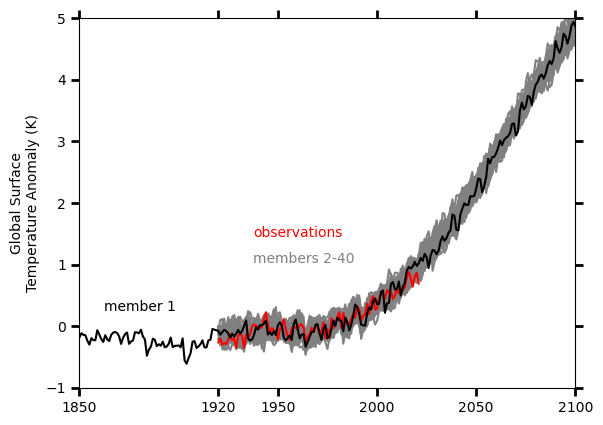

In [27]:
ax = plt.axes()

ax.tick_params(right=True, top=True, direction="out", length=6, width=2, grid_alpha=0.5)
ax.plot(years, all_ts_anom.iloc[:,1:], color="grey")
ax.plot(obs_years, obs_s['1920':], color="red")
ax.plot(member1_years, member1, color="black")


ax.text(
    0.35,
    0.4,
    "observations",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="red",
    fontsize=10,
)
ax.text(
    0.35,
    0.33,
    "members 2-40",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="grey",
    fontsize=10,
)
ax.text(
    0.05,
    0.2,
    "member 1",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
)

ax.set_xticks([1850, 1920, 1950, 2000, 2050, 2100])
plt.ylim(-1, 5)
plt.xlim(1850, 2100)
plt.ylabel("Global Surface\nTemperature Anomaly (K)")
plt.show()

## Figure 4

### Compute linear trend for winter seasons

In [28]:
def linear_trend(da, dim="time"):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(
        calc_slope,
        da_chunk,
        vectorize=True,
        input_core_dims=[[dim]],
        output_core_dims=[[]],
        output_dtypes=[np.float64],
        dask="parallelized",
    )
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))

    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    slope = np.nan if (np.sum(finite_indexes) < 2) else np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    return slope

### Compute ensemble trends

In [29]:
%%time 
# Takes several minutes
t = xr.concat([t_20c, t_rcp], dim="time")
seasons = t.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 and 2012
seasons = seasons.sel(time=slice("1979", "2012")).load()

CPU times: user 24.7 s, sys: 4.86 s, total: 29.5 s
Wall time: 4min 29s


In [30]:
winter_seasons = seasons.sel(
    time=seasons.time.where(seasons.time.dt.month == 12, drop=True)
)
winter_trends = linear_trend(
    winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(winter_seasons.time)

# Compute ensemble mean from the first 30 members
winter_trends_mean = winter_trends.isel(member_id=range(30)).mean(dim='member_id')

Make sure that we have 34 seasons:

In [31]:
assert len(winter_seasons.time) == 34

### Get observations for Figure 4 (NASA GISS GisTemp)

This is observational time series data for comparison with ensemble average. Here we are using the [GISS Surface Temperature Analysis (GISTEMP v4)](https://data.giss.nasa.gov/gistemp/) from NASA's Goddard Institute of Space Studies {cite:p}`Lenssen:2019a`.

```{note}
We will point to Project Pythia's [Jetstream2](https://jetstream-cloud.org) object-store copy of the original time series dataset, in Zarr format. 

The dataset was obtained from [NASA's GISTEMP website](https://data.giss.nasa.gov/gistemp/) in May 2024. 
```

Define the URL to Project Pythia's Jetstream2 Object Store and the path to the Zarr file.

In [32]:
URL = 'https://js2.jetstream-cloud.org:8001'
filePath = 's3://pythia/gistemp1200_GHCNv4_ERSSTv5.zarr'

Create a container for the S3 file system

In [33]:
fs = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=URL))

Link to the Zarr file as it exists on the S3 object store

In [34]:
store = s3fs.S3Map(root=filePath, s3=fs, check=False )

In [35]:
ds = xr.open_zarr(store, consolidated=True, chunks="auto")
ds

<xarray.Dataset> Size: 112MB
Dimensions:      (lat: 90, lon: 180, time: 1730, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-02-15
Dimensions without coordinates: nv
Data variables:
    tempanomaly  (time, lat, lon) float32 112MB dask.array<chunksize=(322, 90, 180), meta=np.ndarray>
    time_bnds    (time, nv) datetime64[ns] 28kB dask.array<chunksize=(1730, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created 2024-03-08 11:37:27 by SBBX_to_nc 2.0 - ILAND=1200,...
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    title:        GISTEMP Surface Temperature Analysis

Create an Xarray `Dataset` from the Zarr object

Remap longitude range from [-180, 180] to [0, 360] for plotting purposes:

In [36]:
ds = ds.assign_coords(lon=((ds.lon + 360) % 360)).sortby('lon')
ds

<xarray.Dataset> Size: 112MB
Dimensions:      (lat: 90, time: 1730, lon: 180, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-02-15
  * lon          (lon) float32 720B 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: nv
Data variables:
    tempanomaly  (time, lat, lon) float32 112MB dask.array<chunksize=(322, 90, 180), meta=np.ndarray>
    time_bnds    (time, nv) datetime64[ns] 28kB dask.array<chunksize=(1730, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created 2024-03-08 11:37:27 by SBBX_to_nc 2.0 - ILAND=1200,...
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    title:        GISTEMP Surface Temperature Analysis

### Compute observed trends

Include only full seasons from 1979 through 2012:

In [37]:
obs_seasons = ds.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
obs_seasons = obs_seasons.sel(time=slice("1979", "2012")).load()
obs_winter_seasons = obs_seasons.sel(
    time=obs_seasons.time.where(obs_seasons.time.dt.month == 12, drop=True)
)
obs_winter_seasons

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 34, lat: 90, lon: 180)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * time         (time) datetime64[ns] 272B 1979-12-01 1980-12-01 ... 2012-12-01
Data variables:
    tempanomaly  (time, lat, lon) float32 2MB 0.5367 0.5367 0.5367 ... 7.04 7.04
Attributes:
    Conventions:  CF-1.6
    history:      Created 2024-03-08 11:37:27 by SBBX_to_nc 2.0 - ILAND=1200,...
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    title:        GISTEMP Surface Temperature Analysis

And compute observed winter trends:

In [38]:
obs_winter_trends = linear_trend(
    obs_winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(obs_winter_seasons.time)
obs_winter_trends

<xarray.Dataset> Size: 131kB
Dimensions:      (lat: 90, lon: 180)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
Data variables:
    tempanomaly  (lat, lon) float64 130kB 1.407 1.407 1.407 ... 5.587 5.587

### Plotting Figure 4

Global maps of historical (1979 - 2012) boreal winter (DJF) surface air trends:

In [39]:
contour_levels = [-6, -5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5, 6]
color_map = cmaps.ncl_default

In [40]:
def make_map_plot(nplot_rows, nplot_cols, plot_index, data, plot_label):
    """ Create a single map subplot. """
    ax = plt.subplot(nplot_rows, nplot_cols, plot_index, projection = ccrs.Robinson(central_longitude = 180))
    cplot = plt.contourf(lons, lats, data,
                         levels = contour_levels,
                         cmap = color_map,
                         extend = 'both',
                         transform = ccrs.PlateCarree())
    ax.coastlines(color = 'grey')
    ax.text(0.01, 0.01, plot_label, fontsize = 14, transform = ax.transAxes)
    return cplot, ax

CPU times: user 1min 40s, sys: 5.33 s, total: 1min 45s
Wall time: 1min 41s


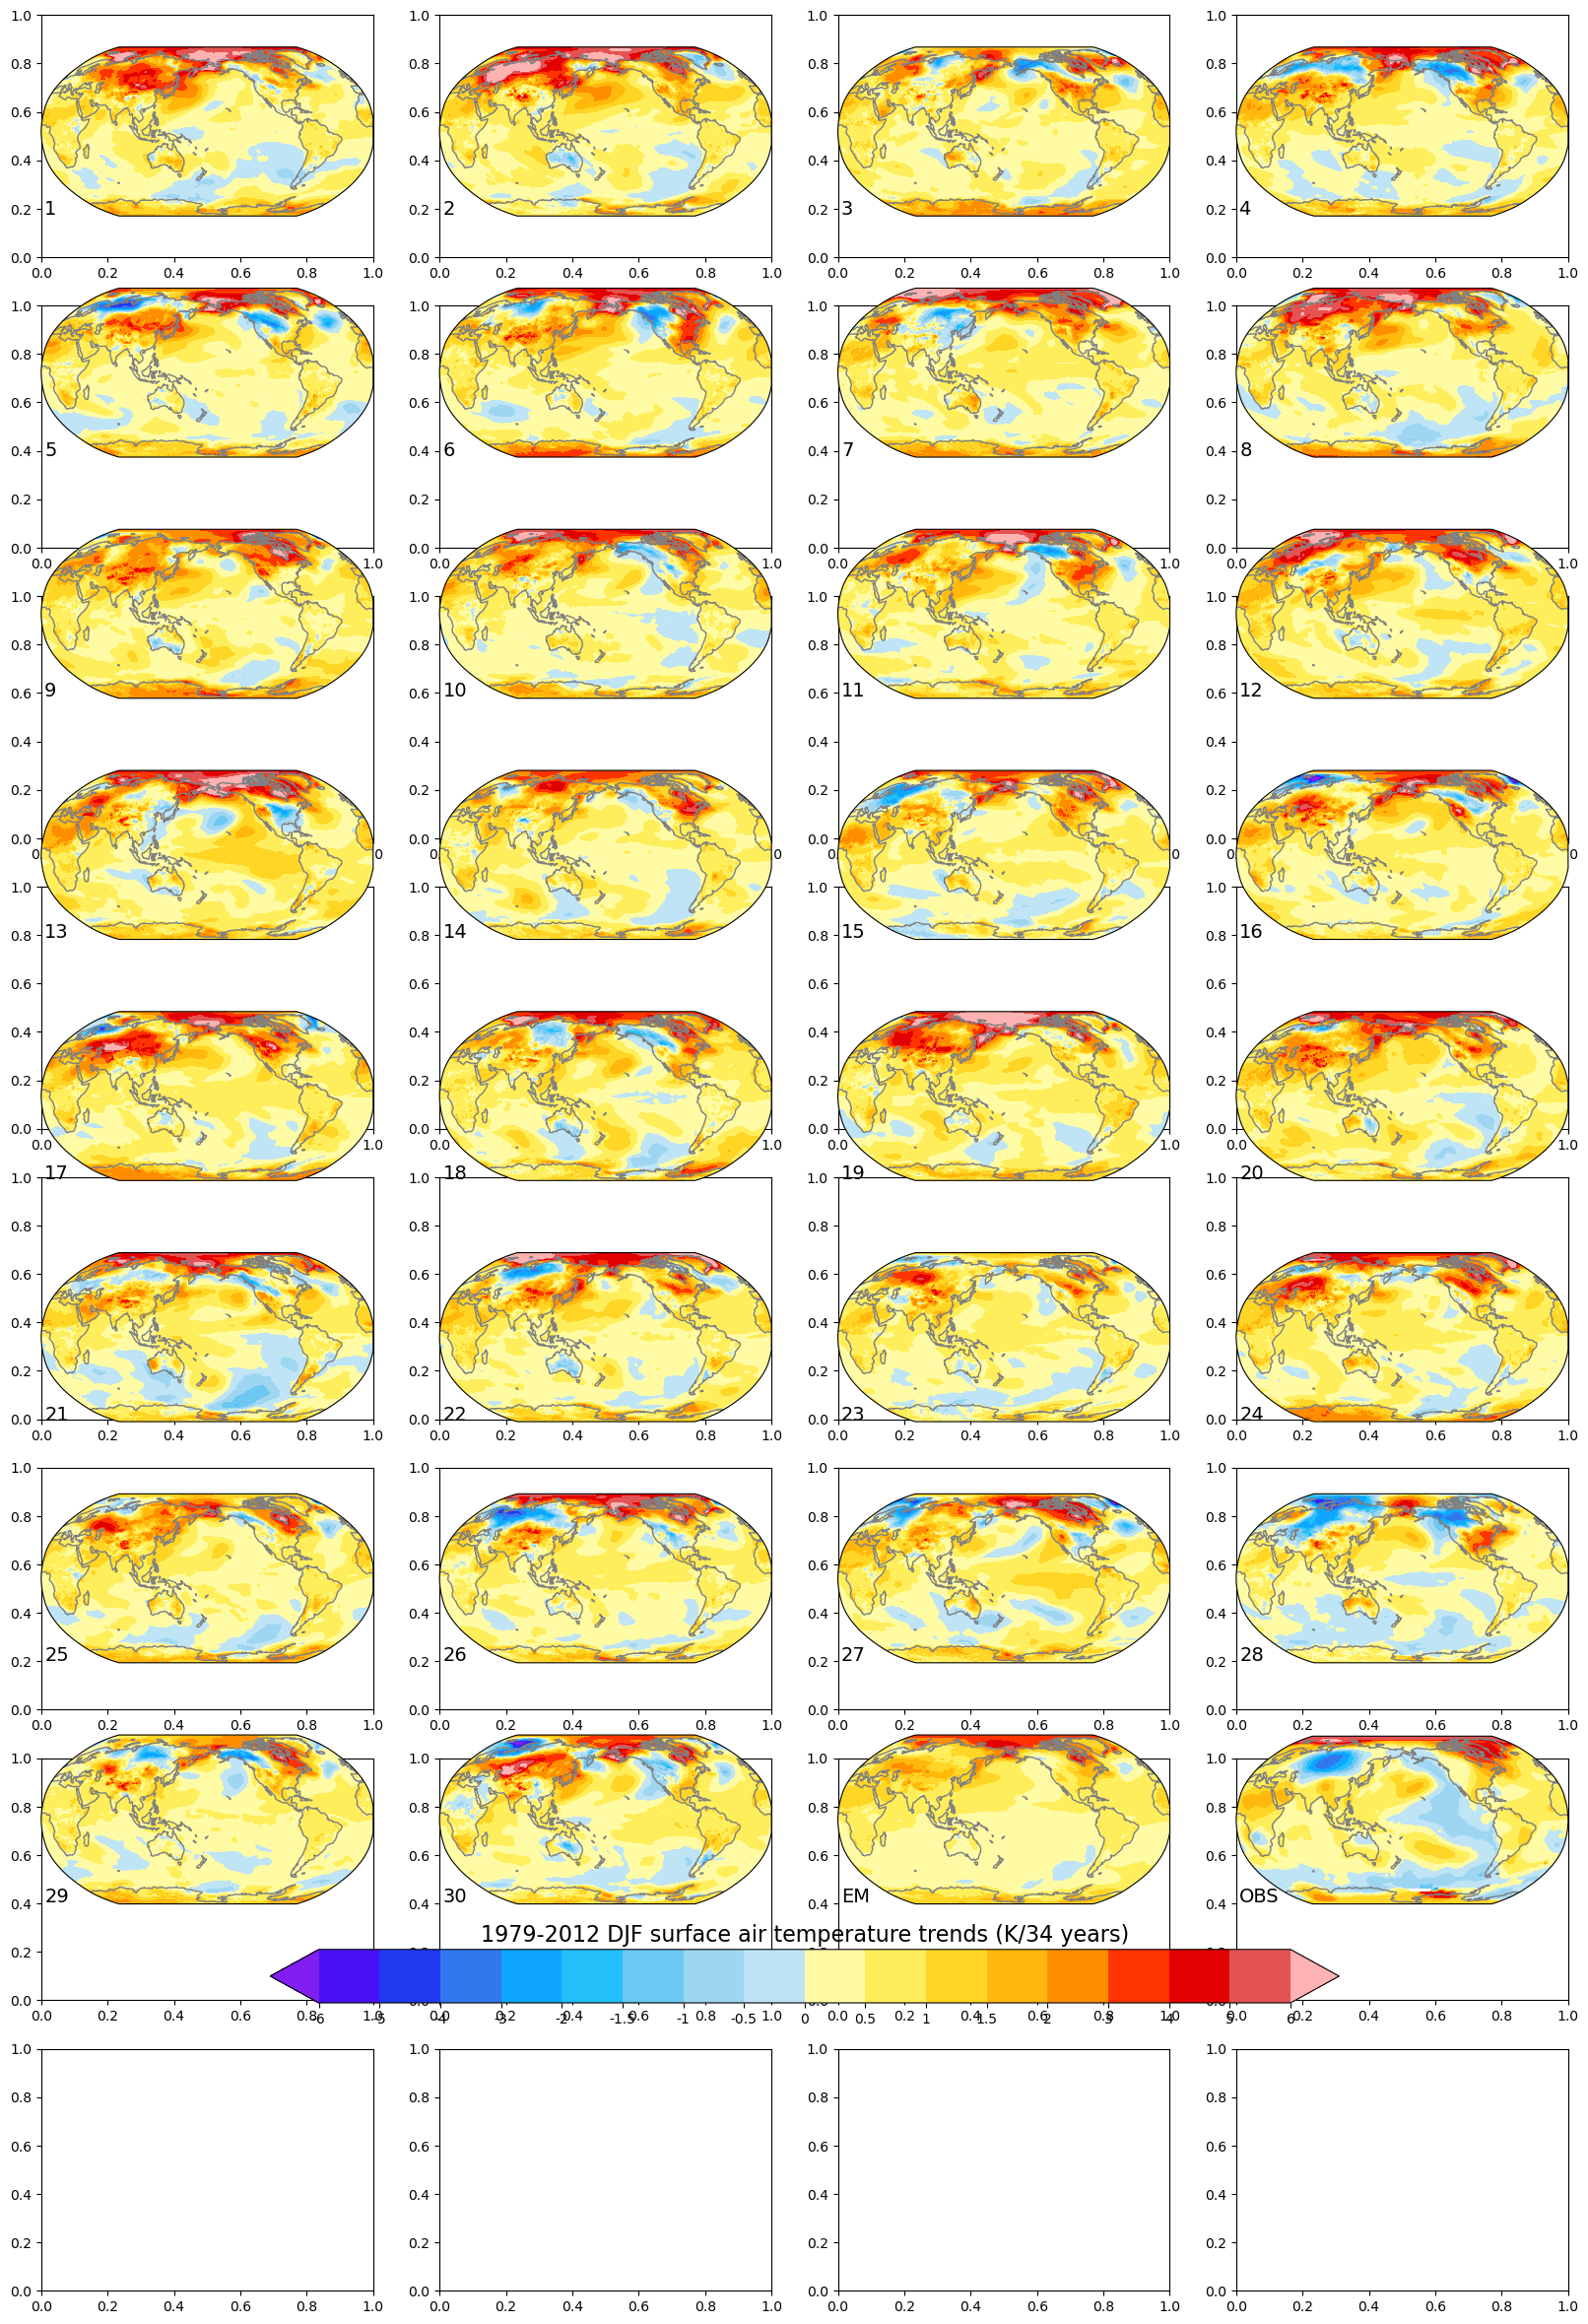

In [41]:
%%time
# Generate plot (may take a while as many individual maps are generated)
numPlotRows = 8
numPlotCols = 4
figWidth = 20
figHeight = 30

fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight))

lats = winter_trends.lat
lons = winter_trends.lon

# Create ensemble member plots
for ensemble_index in range(30):
    plot_data = winter_trends.isel(member_id = ensemble_index)
    plot_index = ensemble_index + 1
    plot_label = str(plot_index)
    plotRow = ensemble_index // numPlotCols
    plotCol = ensemble_index % numPlotCols
    # Retain axes objects for figure colorbar
    cplot, axs[plotRow, plotCol] = make_map_plot(numPlotRows, numPlotCols, plot_index, plot_data, plot_label)

# Create plots for the ensemble mean, observations, and a figure color bar.
cplot, axs[7,2] = make_map_plot(numPlotRows, numPlotCols, 31, winter_trends_mean, 'EM')

lats = obs_winter_trends.lat
lons = obs_winter_trends.lon
cplot, axs[7,3] = make_map_plot(numPlotRows, numPlotCols, 32, obs_winter_trends.tempanomaly, 'OBS')

cbar = fig.colorbar(cplot, ax=axs, orientation='horizontal', shrink = 0.7, pad = 0.02)
cbar.ax.set_title('1979-2012 DJF surface air temperature trends (K/34 years)', fontsize = 16)
cbar.set_ticks(contour_levels)
cbar.set_ticklabels(contour_levels)

Close our client:

In [42]:
client.close()

---

## Summary
In this notebook, we used CESM LENS data hosted on AWS to recreate two key figures in the paper that describes the project.

### What's next?
More example workflows using these datasets may be added in the future.

## Resources and references

1. [Original notebook in the (no longer maintained) Pangeo Gallery](https://gallery.pangeo.io/repos/NCAR/cesm-lens-aws/notebooks/EnhancedIntakeCatalogDemo.html)
2. [Kay et al. (2015): _The Community Earth System Model (CESM) Large Ensemble Project_, BAMS, doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1)
3. [CESM LENS Data Sets on AWS](https://doi.org/10.26024/wt24-5j82)
4. [Morice et al. (2012) paper on HadCRUT4 dataset](https://doi.org/10.1029/2011JD017187)
5. [NASS GISTEMP dataset](https://data.giss.nasa.gov/gistemp/)
6. [Lenssen et al. (2019) paper on latest GISTEMP methods](https://doi.org/10.1029/2018JD029522)